<a href="https://colab.research.google.com/github/HYO2099/DataScienceEcosystem/blob/main/3_modeling_advanced_text_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

# Définir les chemins pour les fichiers source sur Google Drive et destination locale

X_trein_french = '/content/drive/MyDrive/Colab Notebooks/fahim/final/X_trainfr_final.csv'

# Définir les chemins locaux pour stocker les fichiers copiés
local_path = '/content/data/'

# Créer le dossier local si ce n'est pas déjà fait
os.makedirs(local_path, exist_ok=True)

# Copier les fichiers de Google Drive vers l'espace local de Colab

shutil.copy(X_trein_french, local_path)

# Vérifier que les fichiers ont été copiés correctement
print("Fichiers copiés dans l'espace local de Colab.")
print(os.listdir(local_path))

Fichiers copiés dans l'espace local de Colab.
['X_trainfr_final.csv']


In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.3 MB/s eta 0:00:00


 Using: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-eaecbdee8f07>:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  cam_trainer = Trainer(
<ipython-input-5-eaecbdee8f07>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  flaubert_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.698400,0.633122,0.815421,0.813447,0.809516
2,0.528800,0.526414,0.846248,0.844283,0.845117
3,0.357400,0.514662,0.853631,0.852361,0.854560
4,0.346500,0.506215,0.866114,0.864270,0.868064
5,0.273800,0.541689,0.869310,0.868298,0.871926
6,0.190500,0.598642,0.871442,0.870069,0.874006
7,0.175600,0.639681,0.870680,0.869460,0.873826
8,0.124000,0.683356,0.871898,0.870975,0.876283
9,0.141600,0.758319,0.867103,0.867123,0.872801
10,0.095100,0.818760,0.866875,0.865957,0.871008


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.674000,0.603153,0.816715,0.812407,0.811821
2,0.559100,0.527602,0.838864,0.836265,0.837158
3,0.408300,0.518810,0.852870,0.850082,0.853463
4,0.411300,0.486507,0.862917,0.860595,0.864120
5,0.273200,0.543180,0.862612,0.862133,0.866754
6,0.250600,0.618688,0.865505,0.863879,0.866208
7,0.200400,0.743604,0.862841,0.860939,0.863239
8,0.136900,0.769292,0.864515,0.862825,0.866568
9,0.184700,0.822052,0.868016,0.866863,0.871735
10,0.128600,0.953579,0.859339,0.858649,0.863562


CamemBERT: {'eval_loss': 0.8839104175567627, 'eval_accuracy': 0.8747145684274623, 'eval_f1_weighted': 0.8738432925441176, 'eval_f1_macro': 0.8791402198275421, 'eval_runtime': 88.6596, 'eval_samples_per_second': 148.185, 'eval_steps_per_second': 9.271, 'epoch': 15.0}
FlauBERT: {'eval_loss': 1.2829041481018066, 'eval_accuracy': 0.8723550007611509, 'eval_f1_weighted': 0.8714010086251482, 'eval_f1_macro': 0.8764723175636804, 'eval_runtime': 93.8811, 'eval_samples_per_second': 139.943, 'eval_steps_per_second': 8.756, 'epoch': 20.0}

 Meta-classifier CamemBERT + FlauBERT :
Accuracy: 0.8829349977165474
F1-weighted: 0.8820431276084324
F1-macro: 0.8869243010452098
 Logits, labels et modèles sauvegardés.


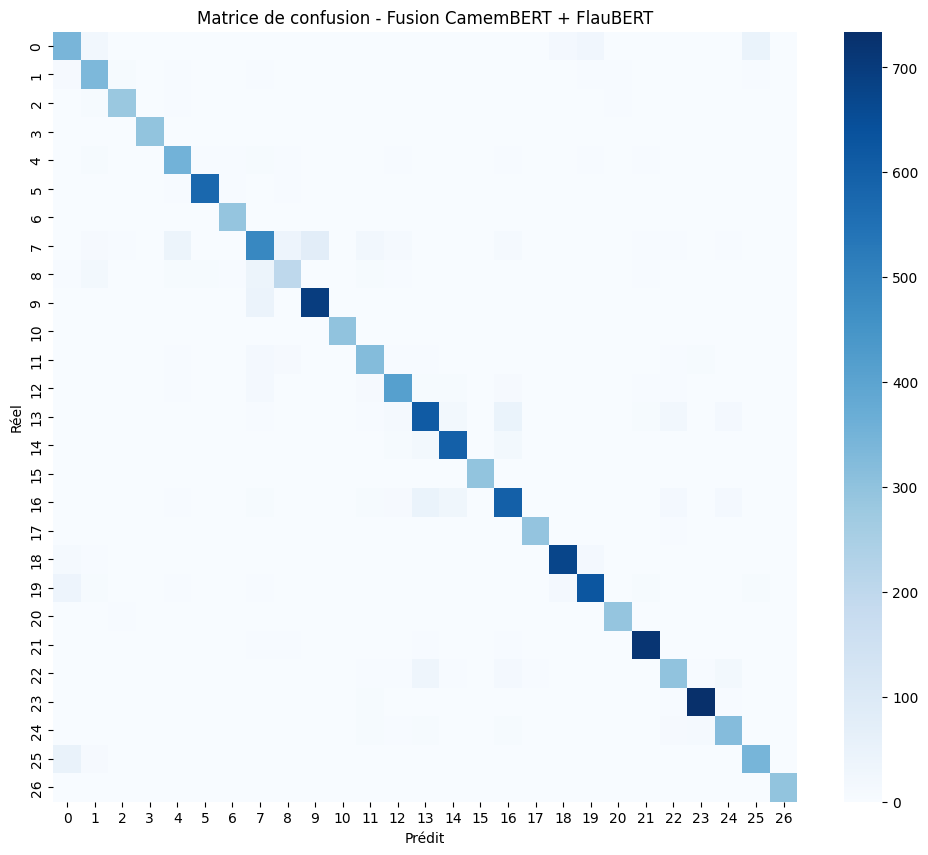

In [ ]:
import torch
from transformers import TrainingArguments
from transformers import (
    CamembertTokenizer, CamembertForSequenceClassification,
    FlaubertTokenizer, FlaubertForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import pandas as pd
import os, joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json



#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using:", device)

#  Données
# Charger le bon fichier final déjà nettoyé + encodé
df = pd.read_csv('/content/data/X_trainfr_final.csv')
le = joblib.load('/content/drive/MyDrive/Colab Notebooks/fahim/final/label_encoder_final.pkl')
#  Split
X_train, X_val, y_train, y_val = train_test_split(
    df['translated_text_combined'], df['label'],
    test_size=0.15, stratify=df['label'], random_state=42
)
num_labels = len(le.classes_)

#  Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length)
        self.labels = labels
    def __getitem__(self, idx):
        return {
            **{k: torch.tensor(v[idx]) for k, v in self.encodings.items()},
            'labels': torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

#  Tokenizers
cam_tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
flaubert_tokenizer = FlaubertTokenizer.from_pretrained("flaubert/flaubert_base_cased")

#  Datasets
cam_ds_train = TextDataset(X_train.tolist(), y_train.tolist(), cam_tokenizer)
cam_ds_val = TextDataset(X_val.tolist(), y_val.tolist(), cam_tokenizer)
flaubert_ds_train = TextDataset(X_train.tolist(), y_train.tolist(), flaubert_tokenizer)
flaubert_ds_val = TextDataset(X_val.tolist(), y_val.tolist(), flaubert_tokenizer)

#  Modèles
cam_model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels).to(device)
flaubert_model = FlaubertForSequenceClassification.from_pretrained("flaubert/flaubert_base_cased", num_labels=num_labels).to(device)

#  Entraînement
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    report_to="none"
)

#  Métriques
def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1_weighted": f1_score(p.label_ids, preds, average='weighted'),
        "f1_macro": f1_score(p.label_ids, preds, average='macro')
    }

#  Trainers
cam_collator = DataCollatorWithPadding(tokenizer=cam_tokenizer)

cam_trainer = Trainer(
    model=cam_model,
    args=training_args,
    train_dataset=cam_ds_train,
    eval_dataset=cam_ds_val,
    tokenizer=cam_tokenizer,
    data_collator=cam_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


flau_collator = DataCollatorWithPadding(tokenizer=flaubert_tokenizer)

flaubert_trainer = Trainer(
    model=flaubert_model,
    args=training_args,
    train_dataset=flaubert_ds_train,
    eval_dataset=flaubert_ds_val,
    tokenizer=flaubert_tokenizer,
    data_collator=flau_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

#  Entraînement
cam_trainer.train()
flaubert_trainer.train()

#  Évaluation
cam_results = cam_trainer.evaluate()
flaubert_results = flaubert_trainer.evaluate()
print("CamemBERT:", cam_results)
print("FlauBERT:", flaubert_results)

#  Late Fusion (moyenne des logits)
cam_preds = cam_trainer.predict(cam_ds_val)
flaubert_preds = flaubert_trainer.predict(flaubert_ds_val)

logits_avg = (torch.tensor(cam_preds.predictions) + torch.tensor(flaubert_preds.predictions)) / 2
meta_preds = logits_avg.argmax(dim=1)
true_labels = torch.tensor(y_val.tolist())

print("\n Meta-classifier CamemBERT + FlauBERT :")
print("Accuracy:", accuracy_score(true_labels, meta_preds))
print("F1-weighted:", f1_score(true_labels, meta_preds, average="weighted"))
print("F1-macro:", f1_score(true_labels, meta_preds, average="macro"))

#  Sauvegarde
torch.save(torch.tensor(cam_preds.predictions), '/content/drive/MyDrive/Colab Notebooks/fahim/final/camembert_logits.pt')
torch.save(torch.tensor(flaubert_preds.predictions), '/content/drive/MyDrive/Colab Notebooks/fahim/final/flaubert_logits.pt')
torch.save(true_labels, '/content/drive/MyDrive/Colab Notebooks/fahim/final/true_labels_image.pt')

model_dir = "/content/drive/MyDrive/Colab Notebooks/fahim/final/models"
os.makedirs(model_dir, exist_ok=True)  #

cam_model.save_pretrained(os.path.join(model_dir, "camembert_model"))
flaubert_model.save_pretrained(os.path.join(model_dir, "flaubert_model"))

results_path = "/content/drive/MyDrive/Colab Notebooks/fahim/final/results_transformers.json"
with open(results_path, "w") as f:
    json.dump({
        "CamemBERT": cam_results,
        "FlauBERT": flaubert_results,
        "Fusion": {
            "accuracy": accuracy_score(true_labels, meta_preds),
            "f1_weighted": f1_score(true_labels, meta_preds, average="weighted"),
            "f1_macro": f1_score(true_labels, meta_preds, average="macro")
        }
    }, f, indent=4)

print(" Logits, labels et modèles sauvegardés.")
cm = confusion_matrix(true_labels, meta_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt='d')
plt.title("Matrice de confusion - Fusion CamemBERT + FlauBERT")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()



In [ ]:
import os, random, torch, joblib
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# --- Réproducibilité ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# --- Dispositif ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Chemins ---
base_final_dir = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
models_dir     = "/content/drive/MyDrive/Colab Notebooks/fahim/models"
os.makedirs(base_final_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# --- LabelEncoder et logits pré-générés ---
le           = joblib.load(os.path.join(base_final_dir, "label_encoder_final.pkl"))
cam_logits   = torch.load(os.path.join(base_final_dir, "camembert_logits.pt"))
fla_logits   = torch.load(os.path.join(base_final_dir, "flaubert_logits.pt"))
true_labels  = torch.load(os.path.join(base_final_dir, "true_labels_image.pt"))

# --- Préparation des données ---
X = torch.cat([cam_logits, fla_logits], dim=1).cpu().numpy()
y = true_labels.cpu().numpy()

# --- Calcul des poids de classes pour la loss ---
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# --- Validation croisée stratifiée ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# --- MLP avec BatchNorm ---
class TextFusionMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

fold_states, fold_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n Fold {fold}/{n_splits}")

    X_train = torch.tensor(X[train_idx], dtype=torch.float32).to(device)
    y_train = torch.tensor(y[train_idx], dtype=torch.long).to(device)
    X_val   = torch.tensor(X[val_idx],   dtype=torch.float32).to(device)
    y_val   = torch.tensor(y[val_idx],   dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train),
                              batch_size=512, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val,   y_val),
                              batch_size=512, shuffle=False)

    model     = TextFusionMLP(input_dim=X.shape[1],
                              num_classes=len(le.classes_)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=1, verbose=True
    )

    best_f1, no_improve, patience = 0.0, 0, 3
    best_state = None

    for epoch in range(1, 16):
        # — Entraînement —
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out   = model(xb)
            loss  = criterion(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        # — Validation —
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                preds.extend(out.argmax(dim=1).cpu().numpy())
                trues.extend(yb.cpu().numpy())

        val_f1 = f1_score(trues, preds, average="weighted")
        scheduler.step(val_f1)

        print(f"  Epoch {epoch:02d} — Val F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1, best_state, no_improve = val_f1, model.state_dict(), 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"  Early stop at epoch {epoch}")
                break

    fold_scores.append(best_f1)
    fold_states.append(best_state)

print(f"\n F1 par fold: {fold_scores}")
print(f" CV mean: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

# --- Sauvegarde du meilleur modèle global ---
best_fold = int(np.argmax(fold_scores))
model_final = TextFusionMLP(input_dim=X.shape[1],
                           num_classes=len(le.classes_)).to(device)
model_final.load_state_dict(fold_states[best_fold])
torch.save(model_final.state_dict(),
           os.path.join(models_dir, "fusion_text_mlp_best.pt"))

# --- Sauvegarde des logits finaux ---
model_final.eval()
all_X = torch.tensor(X, dtype=torch.float32).to(device)
fusion_logits = model_final(all_X).detach().cpu()
torch.save(fusion_logits,
           os.path.join(base_final_dir, "fusion_text_mlp_logits.pt"))

print(f" Modèle & logits sauvegardés.")
